<a href="https://colab.research.google.com/github/camilodlt/rtidy-python/blob/main/Computer%20vision/CIFAR/Trying_out_the_functional_AK_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **AutoKeras Functional API for Image Classification** 

In the previous notebook we achieved a really high accuracy score (92%) on the test set using just the basic autoKeras API. 

This time we will try to obtain similar results using the functional API, specially, using the recent feature of merging models. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
!pip install autokeras
!pip install tensorflow==2.4.3

In [3]:
!nvidia-smi

Wed Sep  8 06:41:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    25W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import tensorflow as tf 
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# import the python packages
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import tensorflow as tf
tf.random.set_seed(42)
from tensorflow.keras.datasets import mnist, cifar10

import autokeras as ak

print( "tf.__version__:", tf.__version__ )
print( "ak.__version__:", ak.__version__ )

tf.__version__: 2.4.3
ak.__version__: 1.0.16


## Load dataset

In [6]:
# Load dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('Training image shape:', x_train.shape)
print('Training label shape:', y_train.shape)
print('Testing image shape:', x_test.shape)
print('Testing label shape:', y_test.shape)

170500096/170498071 [==============================] - 2s 0us/step
Training image shape: (50000, 32, 32, 3)
Training label shape: (50000, 1)
Testing image shape: (10000, 32, 32, 3)
Testing label shape: (10000, 1)


#### Load cifar10

In [7]:
# scale
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# reshape
x_train = x_train.reshape(-1, 32, 32, 3)
x_test = x_test.reshape(-1, 32, 32, 3)
print('Training image shape:', x_train.shape)
print('Training label shape:', y_train.shape)
print('Testing image shape:', x_test.shape)
print('Testing label shape:', y_test.shape)

Training image shape: (50000, 32, 32, 3)
Training label shape: (50000, 1)
Testing image shape: (10000, 32, 32, 3)
Testing label shape: (10000, 1)


In [8]:
# NORMALIZE ------
scaler = StandardScaler()
x_train=scaler.fit_transform(x_train.reshape((-1,32*32*3)))
x_test= scaler.transform(x_test.reshape((-1,32*32*3)))

# Reshaping ---
x_train=x_train.reshape((-1,32,32,3))
x_test=x_test.reshape((-1,32,32,3))

means= scaler.mean_
stds= scaler.var_

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 31.5, 31.5, -0.5)

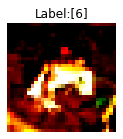

In [9]:
from sklearn.utils import resample
x_train_sampled, y_train_sampled = resample(x_train, y_train, n_samples=10000, replace=False, random_state=0)

image = x_train[0]
label = y_train[0]

# The normal figure
plt.figure( figsize=(2,2) )
plt.tight_layout()
plt.imshow(x_train[0].reshape(32,32,3), interpolation='none') # Of course our image has now normalized values for pixels. 
plt.title("Label:{}".format(y_train[0]))
plt.axis('off')

#### Plot first 12 images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

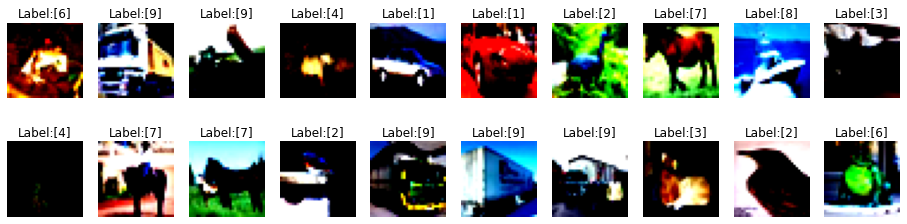

In [10]:
# plot first 12 images
plt.figure( figsize=(16,4) )
plt.tight_layout()
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(x_train[i].reshape(32,32,3))
    plt.title("Label:{}".format(y_train[i]))
    plt.axis('off')

#### Prepare data

## Build automated deep learning model

#### Build model with Functional API

In [11]:
# Build model with the Functional API and the built-in blocks of AutoKeras
inputs = ak.ImageInput()
#x = ak.Normalization()(inputs)
convnet = ak.ConvBlock()(inputs)
resnet = ak.ResNetBlock(version="v2")(inputs)
merge = ak.Merge()([convnet, resnet])
outputs = ak.ClassificationHead()(resnet) # Merge two NN paths

clf = ak.AutoModel(
    inputs=inputs, 
    outputs=outputs,
    max_trials=6,
    overwrite=True,
    seed=42)

clf.fit(x_train_sampled, y_train_sampled, epochs=5,batch_size=128)

Trial 6 Complete [00h 04m 21s]
val_loss: 2.2083070278167725

Best val_loss So Far: 1.5282777547836304
Total elapsed time: 00h 56m 40s
INFO:tensorflow:Oracle triggered exit
Epoch 1/5
79/79 [==============================] - 166s 2s/step - loss: 3.4842 - accuracy: 0.1972
Epoch 2/5
79/79 [==============================] - 159s 2s/step - loss: 1.9774 - accuracy: 0.3132
Epoch 3/5
79/79 [==============================] - 159s 2s/step - loss: 1.7224 - accuracy: 0.4187
Epoch 4/5
79/79 [==============================] - 159s 2s/step - loss: 1.6396 - accuracy: 0.4787
Epoch 5/5
79/79 [==============================] - 159s 2s/step - loss: 1.5260 - accuracy: 0.5017
INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


## Explore Model

In [12]:
# Get the summarized results during the tuning process (return the best 10 models if existed)
clf.tuner.results_summary()

Results summary
Results in ./auto_model
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
res_net_block_1/pretrained: False
res_net_block_1/version: resnet50_v2
res_net_block_1/imagenet_size: True
classification_head_1/spatial_reduction_1/reduction_type: global_max
classification_head_1/dropout: 0
optimizer: adam
learning_rate: 0.001
Score: 1.5282777547836304
Trial summary
Hyperparameters:
res_net_block_1/pretrained: False
res_net_block_1/version: resnet50_v2
res_net_block_1/imagenet_size: True
classification_head_1/spatial_reduction_1/reduction_type: flatten
classification_head_1/dropout: 0
optimizer: adam
learning_rate: 0.001
Score: 1.5661448240280151
Trial summary
Hyperparameters:
res_net_block_1/pretrained: False
res_net_block_1/version: resnet50_v2
res_net_block_1/imagenet_size: True
classification_head_1/spatial_reduction_1/reduction_type: flatten
classification_head_1/dropout: 0.25
optimizer: adam
learning_rate: 0.001
Score: 1.8995

In [13]:
#Retrieve best model
best_model = clf.export_model()
best_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 32, 32, 3)         0         
_________________________________________________________________
resizing (Resizing)          (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
_________________________________________________________________
classification_head_1 (Softm (None, 10)                0     

In [14]:
# Saving the model 
best_model.save('/content/drive/MyDrive/Autokeras/auto_keras_best')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Autokeras/auto_keras_best/assets


One problem is that the best model found is rather complicated, it follows a classical resnet architecture with residual connections but does a weird job augmenting an decreasing the number of filters by 1x1 convolutions. (ex pass from 2048 to 512 and then to 2048 again at the end). 

We asked for a Merge between a Conv block and a Resnet but at the end, the conv block does not even show up.

It is interesting to see that good results were obtained even with resizing the input image at such high ratio. (32,32 to 224, 224).

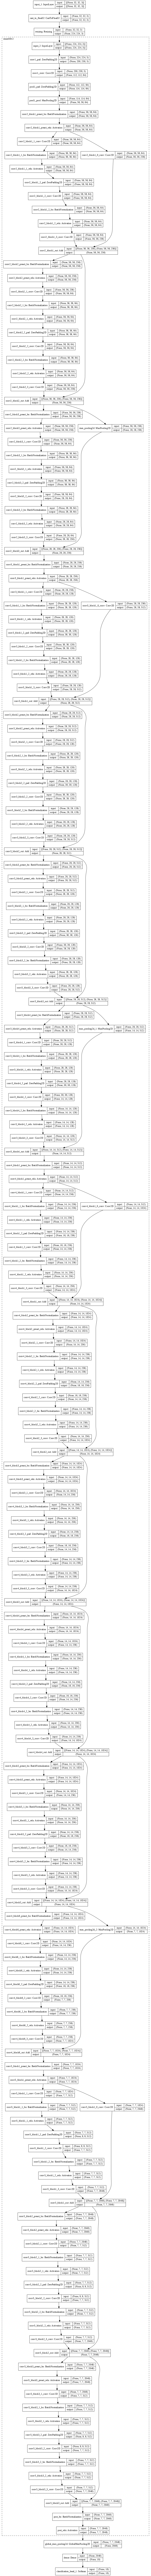

In [16]:
# Converts a Keras model to dot format and plot an image
tf.keras.utils.plot_model(best_model, show_layer_names=True, show_shapes=True, expand_nested=True, dpi=64)

## Retrain and evaluate searched model

In [17]:
(x_train, y_train), (x_test, y_test) =  cifar10.load_data()

# scale
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# reshape
x_train = x_train.reshape(-1, 32, 32, 3)
x_test = x_test.reshape(-1, 32, 32, 3)
print('Training image shape:', x_train.shape)
print('Training label shape:', y_train.shape)
print('Testing image shape:', x_test.shape)
print('Testing label shape:', y_test.shape)

# Normalizing ---
x_train=scaler.transform(x_train.reshape((-1,32*32*3)))
x_test= scaler.transform(x_test.reshape((-1,32*32*3)))

# Reshaping ---
x_train=x_train.reshape((-1,32,32,3))
x_test=x_test.reshape((-1,32,32,3))

# compile the model and train the model
best_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
best_model.fit(x_train, y_train, epochs=20, batch_size=64, validation_split=0.20)

Training image shape: (50000, 32, 32, 3)
Training label shape: (50000, 1)
Testing image shape: (10000, 32, 32, 3)
Testing label shape: (10000, 1)
Epoch 1/20
625/625 [==============================] - 725s 1s/step - loss: 2.0192 - accuracy: 0.3844 - val_loss: 1.6847 - val_accuracy: 0.4013
Epoch 2/20
625/625 [==============================] - 715s 1s/step - loss: 1.5039 - accuracy: 0.5169 - val_loss: 1.4371 - val_accuracy: 0.5826
Epoch 3/20
625/625 [==============================] - 714s 1s/step - loss: 1.2687 - accuracy: 0.6097 - val_loss: 1.4567 - val_accuracy: 0.6541
Epoch 4/20
625/625 [==============================] - 714s 1s/step - loss: 0.9932 - accuracy: 0.6808 - val_loss: 0.9178 - val_accuracy: 0.6992
Epoch 5/20
625/625 [==============================] - 714s 1s/step - loss: 0.8208 - accuracy: 0.7327 - val_loss: 0.8816 - val_accuracy: 0.7223
Epoch 6/20
625/625 [==============================] - 714s 1s/step - loss: 0.6872 - accuracy: 0.7767 - val_loss: 0.7144 - val_accuracy: 0.7

#### Evaluate the searched model

We have to be really careful with overfitting. Our resnet model takes a really long time to train and it does not produce the same results as the model we trained in the last notebook. 

The previous notebook used an efficientnet, obtained better results and was lighter. 

In [18]:
# evaluate the model
test_loss, test_acc = best_model.evaluate(x_test, y_test, verbose=1)
print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

313/313 [==============================] - 58s 181ms/step - loss: 1.1616 - accuracy: 0.7773
Test loss:  1.1616184711456299
Test accuracy:  0.7773000001907349


#### Case Study

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


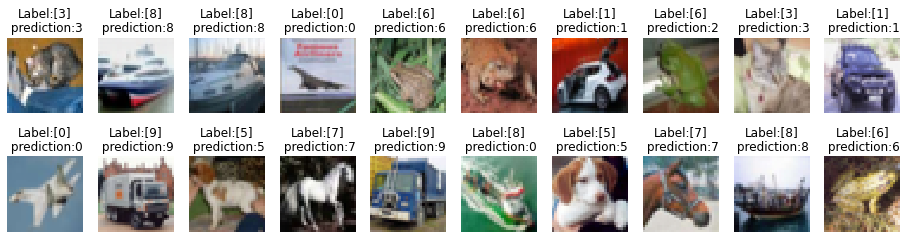

In [36]:
import numpy as np
# make prediction and plot the results
y_predictions = best_model.predict( x_test[:32] ).argmax(axis = 1)

plt.figure( figsize=(16,4) )
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow((x_test[i].reshape((3072))*np.sqrt(stds)+means).reshape(32,32,3), cmap='gray', interpolation='none')
    plt.title("Label:{}\n prediction:{}".format(y_test[i], y_predictions[i]))
    plt.axis('off')

In [20]:
# Saving the model 
best_model.save('/content/drive/MyDrive/Autokeras/auto_keras_best_fitted_20e')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Autokeras/auto_keras_best_fitted_20e/assets
